# Few-Shot Learning Email Classification with Pre-Trained Word2Vec Embeddings

In [1]:
import pandas as pd
import numpy as np
from random import seed
from random import sample
from wordfile import func
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import re
import gensim.downloader as api
from gensim.models.keyedvectors import Word2VecKeyedVectors
import joblib
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from scipy import spatial
import os
import spacy

In [2]:
model = api.load('word2vec-google-news-300')

In [3]:
# from google.colab import files
# uploaded = files.upload()

In [87]:
df = pd.read_csv("./emaildataset.csv", usecols = ['Subject','Body', 'Class'])
df.head()

,Subject,Body,Class
0,Transaction no. 072558 is unresolved.,Sorry to inform that there has been only a par...,Pending
1,Order for new Cheque book,"Good morning, I want to place an order for an ...",General
2,Required money acquired. Transaction 847047 is...,Hello! This is to inform you that I have recei...,Processing
3,Asking for the details for transaction 746078,I request you to kindly send the status of my ...,Request
4,Partial payment for transaction 535918,Hello!! Greetings for the day. Status of trans...,Pending


In [88]:
nlp = spacy.load('en')

In [89]:
my_stop = ["'d", "'ll", "'m", "'re", "'s", "'ve",'a','cc','subject','http', 'gbp', 'usd', 'eur', 'inr', 'cad', 'thanks', "acc", "id", 'account', 'regards', 'hi', 'hello', 'thank you', 'greetings', 'about','above', 'across','after','afterwards','alone','along','am','among', 'amongst','amount','an','and','another','any','anyhow','anyone','anything','anyway','anywhere','are','around','as', 'at','be','became','because','become','becomes','becoming','been','before','beforehand','behind','being','below', 'beside','besides','between','both','bottom','but','by','ca','call','can','could','did', 'do', 'does', 'doing', 'down', 'due', 'during', 'each', 'eight', 'either', 'eleven', 'else', 'elsewhere', 'everyone', 'everything', 'everywhere', 'fifteen', 'fifty', 'first', 'five', 'for', 'former', 'formerly', 'forty', 'four', 'from', 'front', 'further', 'get', 'give', 'go', 'had', 'has', 'have', 'he', 'hence', 'her', 'here', 'hereafter', 'hereby', 'herein', 'hereupon', 'hers', 'herself', 'him', 'himself', 'his', 'how', 'however', 'hundred', 'i', 'if', 'in', 'indeed', 'into', 'is', 'it', 'its', 'itself', 'just', 'keep', 'last', 'latter', 'latterly', 'least', 'less', 'made', 'make', 'many', 'may', 'me', 'meanwhile', 'might', 'mine', 'more', 'moreover', 'move', 'much', 'must', 'my', 'myself', 'name', 'namely', 'neither', 'nevertheless', 'next', 'nine', 'no', 'nobody', 'now', 'nowhere', 'of', 'off', 'often', 'on', 'one', 'onto', 'or', 'other', 'others', 'otherwise', 'our', 'ours', 'ourselves', 'out', 'own', 'part', 'per', 'perhaps', 'please', 'put', 'quite', 'rather', 're', 'really', 'regarding', 'same', 'say', 'see', 'seem', 'seemed', 'seeming', 'seems', 'she', 'should', 'show', 'side', 'since', 'six', 'sixty', 'so', 'some', 'somehow', 'someone', 'something', 'sometime', 'somewhere', 'such', 'take', 'ten', 'than', 'that', 'the', 'their', 'them', 'themselves', 'then', 'thence', 'there', 'thereafter', 'thereby', 'therefore', 'therein', 'thereupon', 'these', 'they', 'third', 'this', 'those', 'three', 'through', 'throughout', 'thru', 'thus', 'to', 'together', 'too', 'top', 'toward', 'towards', 'twelve', 'twenty', 'two', 'under', 'up', 'upon', 'us', 'using', 'various', 'via', 'was', 'we', 'well', 'were', 'whatever', 'whence', 'whenever', 'whereafter', 'whereas', 'whereby', 'wherein', 'whereupon', 'wherever', 'whether', 'which', 'while', 'whither', 'whoever', 'whole', 'whom', 'whose', 'will', 'with', 'within', 'would', 'yet', 'you', 'your', 'yours', 'yourself', 'yourselves', '‘d', '‘ll', '‘m', '‘re', '‘s', '‘ve', '’d', '’ll', '’m', '’re', '’s', '’ve']


In [90]:
def get_only_chars(text):    
    text = text.replace("-", " ") #replace hyphens with spaces
    text = text.replace("\t", " ")
    text = text.replace("\n", " ")

    text=text.rstrip()
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    t = ""

    for i in text.lower().split():
        if func(i) is not None:
            t += func(i) + " "
        else :
            t += i + " "

    t = t.rstrip()
    
    text = " ".join([i for i in t.lower().split()])
    text = " ".join(token for token in text.split() if token not in my_stop)

    doc = nlp(text)
    
    doc = " ".join(token.orth_ for token in doc if not token.is_punct | token.is_space)
    return doc

In [91]:
print(get_only_chars("hi i want info on le 12234."))

want info legal entity


In [92]:
for i in range(df.shape[0]):
    # merge subject and body strings
    df['Text'] = (df['Subject'] + " " + df['Body'])

In [93]:
def converter(x):
    try:
        return ' '.join([x.lower() for x in str(x).split()])
    except AttributeError:
        return None  # or some other value

df['Text'] = df['Text'].apply(converter)

In [94]:
text_clean=[]

for i in range(df.shape[0]):
    text_clean.append(get_only_chars(df.loc[i]['Text']))

In [95]:
df['Text'] = df['Text'].apply(lambda x: get_only_chars(x))

In [96]:
df = df.drop_duplicates('Text')

In [97]:
df.shape

(355, 4)

In [98]:
df.sample(frac=1).reset_index(drop=True)

,Subject,Body,Class,Text
0,Payment is pending for transaction 817628,"Since my transaction 817628 is still pending, ...",Pending,payment pending transaction transaction pendin...
1,Partial payment for transaction 643082,The transaction 643082 is taking too long to c...,Pending,partial payment transaction transaction taking...
2,Failure of transaction 104328,This is in response to your email stating that...,Failed,failure transaction response email stating tra...
3,Urgently required update on transaction 648334,I request you to kindly send the status of my ...,Request,urgently required update transaction request k...
4,Send steps to activate online banking,Kindly add the contact no. 7102106931 to my ba...,General,send steps activate online banking kindly add ...
...,...,...,...,...
350,Payment received for transaction : 130956 and ...,Hello! This is to inform you that I have recei...,Processing,payment received transaction processing inform...
351,Partial payment for transaction 604428,"Since my transaction 604428 is still pending, ...",Pending,partial payment transaction transaction pendin...
352,Upgrade to an account with more benefits,I need a new cheque book of 25 leaves. Kindly ...,General,upgrade benefits need new cheque book leaves k...
353,Transaction no. 072558 is unresolved.,Sorry to inform that there has been only a par...,Pending,transaction unresolved sorry inform partial pa...


In [99]:
# set the by default to:
num_classes = df.Class.unique() # the number of classes we consider (since the dataset has many classes)
sample_size = 2 # the number of labeled sampled we’ll require from the user

In [100]:
smallest_sample_size = min(df['Class'].value_counts())

In [101]:
# Generate samples that contains K samples of each class

def gen_sample(sample_size, num_classes):

    df_1 = df[(df["Class"] < num_classes+1)].reset_index().drop(["index"], axis=1).reset_index().drop(["index"], axis=1)
    
    train = df_1[df_1["Class"] == np.unique(df_1['Class'])[0]].sample(sample_size)
#     return train
    train_index = train.index.tolist()

    for i in range(1,num_classes):
        train_2 = df_1[df_1["Class"] == np.unique(df_1['Class'])[i]].sample(sample_size)
        train = pd.concat([train, train_2], axis=0)
        train_index.extend(train_2.index.tolist())

    test = df_1[~df_1.index.isin(train_index)]
    return train, test

In [102]:
from sklearn.preprocessing import LabelEncoder 

le = LabelEncoder()
df['Class'] = le.fit_transform(df['Class'])

In [103]:
# df['Class'] = df['Class'].apply(lambda x : x + 1)

In [104]:
df.head(20)

,Subject,Body,Class,Text
0,Transaction no. 072558 is unresolved.,Sorry to inform that there has been only a par...,3,transaction unresolved sorry inform partial pa...
1,Order for new Cheque book,"Good morning, I want to place an order for an ...",2,order new cheque book good morning want place ...
2,Required money acquired. Transaction 847047 is...,Hello! This is to inform you that I have recei...,4,required money acquired transaction process in...
3,Asking for the details for transaction 746078,I request you to kindly send the status of my ...,5,asking details transaction request kindly send...
4,Partial payment for transaction 535918,Hello!! Greetings for the day. Status of trans...,3,partial payment transaction day status transac...
5,Payment done and Transaction 683241 settled.,Greetings! I wanted to let you know that I hav...,0,payment done transaction settled wanted let kn...
6,Failure of transaction 608189,This is to notify you that my transaction 6081...,1,failure transaction notify transaction failed ...
7,Send steps to activate online banking,"Hey, I have to transfer funds to a different b...",2,send steps activate online banking hey transfe...
8,Incomplete transaction 947071,I regret to inform you that I could only pay t...,3,incomplete transaction regret inform pay parti...
9,Failure of transaction 443004,"Hey, I see my transaction with ID 443004 has f...",1,failure transaction hey transaction failed thi...


In [105]:
df.Class.value_counts()

2    75
5    72
3    66
0    52
1    49
4    41
Name: Class, dtype: int64

In [106]:
for i in range(0, 6):
    print(i)
    print(le.inverse_transform([i]))

0
['Complete']
1
['Failed']
2
['General']
3
['Pending']
4
['Processing']
5
['Request']


In [107]:
# Text processing (split, find token id, get embedidng)
def transform_sentence(text, model):

    def preprocess_text(raw_text, model=model):

        raw_text = raw_text.split()
        return list(filter(lambda x: x in model.vocab, raw_text))

    tokens = preprocess_text(text)

    if not tokens:
        return np.zeros(model.vector_size)

    text_vector = np.mean(model[tokens], axis=0)
    return np.array(text_vector)

## Pre-trained Word2Vec and ML algorithms

In [108]:
# Install with below cell if you're not able to install on terminal

# import sys
# !{sys.executable} -m pip install xgboost

In [109]:
import xgboost

In [110]:
def return_score_xgb(sample_size, num_classes):

    train, test = gen_sample(sample_size, num_classes)

    X_train = train['Text'].values
    y_train = train['Class'].values
    X_test = test['Text'].values
    y_test = test['Class'].values

    X_train_mean = np.array([transform_sentence(x, model) for x in X_train])
    X_test_mean = np.array([transform_sentence(x, model) for x in X_test])

#     XG Boost
    clf = xgboost.XGBClassifier()
    clf.fit(X_train_mean, y_train)

    if not os.path.exists('./pkl_objects'):
        os.mkdir('./pkl_objects')
    
    joblib.dump(le, './pkl_objects/labelencoder.pkl')
    joblib.dump(clf, './pkl_objects/clf.pkl')

    y_pred = clf.predict(X_test_mean)

    return accuracy_score(y_pred, y_test)

## Comparison of accuracies

In [111]:
all_accuracy_xgb = {2:[],3:[],4:[],5:[],6:[],7:[]}

for num_samples in range(1, 40):

    for num_cl in range(2, 7):

        all_accuracy_xgb[num_cl].append(return_score_xgb(num_samples,num_cl))

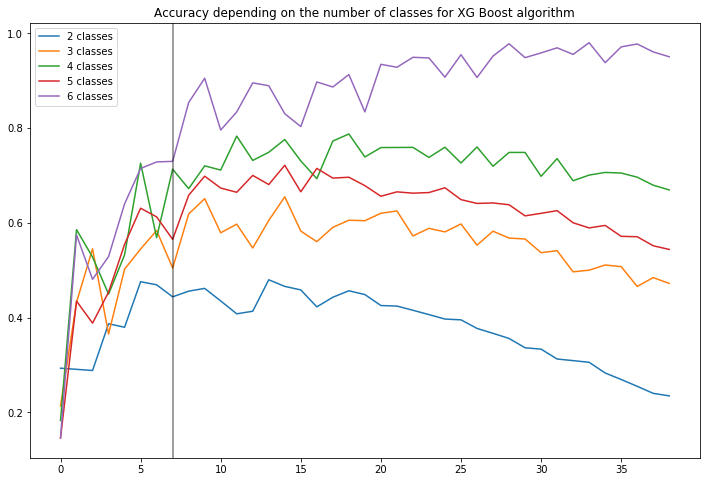

<Figure size 432x288 with 0 Axes>

In [112]:
plt.figure(figsize=(12,8))
plt.plot(all_accuracy_xgb[2], label="2 classes")
plt.plot(all_accuracy_xgb[3], label="3 classes")
plt.plot(all_accuracy_xgb[4], label="4 classes")
plt.plot(all_accuracy_xgb[5], label="5 classes")
plt.plot(all_accuracy_xgb[6], label="6 classes")
plt.axvline(7, c='black', alpha=0.5)

plt.title("Accuracy depending on the number of classes for XG Boost algorithm")
plt.legend()
plt.show()
plt.savefig('accuracy_plot.jpg')

## Summary

In [113]:
df_results = pd.DataFrame({
    
    'Nb Classes':[2, 3, 4, 5, 6], 

    'mean XG Boost':[np.mean(all_accuracy_xgb[2]), 
        np.mean(all_accuracy_xgb[3]), 
        np.mean(all_accuracy_xgb[4]), 
        np.mean(all_accuracy_xgb[5]),
        np.mean(all_accuracy_xgb[6])],
    'max XG Boost':[max(all_accuracy_xgb[2]), 
        max(all_accuracy_xgb[3]), 
        max(all_accuracy_xgb[4]), 
        max(all_accuracy_xgb[5]),
        max(all_accuracy_xgb[6])]
    })

In [114]:
df_results

,Nb Classes,mean XG Boost,max XG Boost
0,2,0.379902,0.479730
1,3,0.544966,0.654822
2,4,0.689921,0.787440
3,5,0.610342,0.721429
4,6,0.844826,0.980132


## Testing on incoming email 

In [115]:
le = joblib.load('./pkl_objects/labelencoder.pkl')
clf = joblib.load('./pkl_objects/clf.pkl')

In [118]:
def inp(emailto, emailfrom, subj, bod):
    text = subj + " " + bod
    text = get_only_chars(text)
    X_test_mean = np.array([transform_sentence(text, model)])

    y_pred = clf.predict(X_test_mean)
    print(y_pred)

    return le.inverse_transform(y_pred)

In [119]:
print(inp("fvf", "defrfg", "payment processed", "hi, the payment for acc 1234 for usd 3456 was paid successfully."))

[0]
['Complete']


In [120]:
print(inp("cfdfv", "derftrg", "Partially paid the required amount for transaction", "There has been only a partial payment of amount 1234"))

[3]
['Pending']
